In [281]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [282]:
df=pd.read_csv("/content/train_star.csv")

In [283]:
print(df.head(),df.info(),df.isna().sum(),df.columns,sep="\n\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20732 entries, 0 to 20731
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Vmag         20732 non-null  float64
 1   Plx          20732 non-null  float64
 2   e_Plx        20732 non-null  float64
 3   B-V          20732 non-null  float64
 4   SpType       20732 non-null  object 
 5   Amag         20732 non-null  float64
 6   TargetClass  20732 non-null  object 
dtypes: float64(5), object(2)
memory usage: 1.1+ MB
    Vmag    Plx  e_Plx    B-V  SpType       Amag TargetClass
0   9.99   7.92   1.61  0.646  G5/G6V  19.483625       Giant
1  10.86   3.26   2.12  1.840    M1V:  18.426088       Giant
2   8.83   7.57   1.05  0.461     F3V  18.225480       Giant
3   7.72  24.80   0.89  0.613    G3IV  19.692257       Giant
4   8.81   3.17   1.03  0.872   G6III  16.315296       Dwarf

None

Vmag           0
Plx            0
e_Plx          0
B-V            0
SpType         0
Amag

In [284]:
x=set(''.join(list(df["SpType"])))
print(x)

{')', 'N', '5', 'c', '3', 'l', 'B', 'r', 'C', 'o', '-', 'i', 'M', ':', '9', 'K', 'F', 'b', 'm', '7', 's', '/', 'v', 'p', 'g', 'I', 'n', '0', ' ', 'H', '+', '1', 'h', '6', '2', 'a', 'T', '(', 'V', '8', '.', 'O', 'A', 'S', 'e', 'w', '4', 'G'}


In [285]:
#Sp type has compact data to be extracted
df["SpectralClass"]=df["SpType"].str[0]
df["SubClass"]=pd.to_numeric(df["SpType"].str[1],errors="coerce")
df["SubClass"]=df["SubClass"].fillna(df["SubClass"].median())

def extract_luminosity(s):
    if pd.isna(s):
        return None
    s=s.replace(":", "")
    match=re.search(r"(Ia|Ib|Iab|I|II|III|IV|V)$", s)
    return match.group(1) if match else None

df["LuminosityClass"]=df["SpType"].apply(extract_luminosity)
df.head()

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass,SpectralClass,SubClass,LuminosityClass
0,9.99,7.92,1.61,0.646,G5/G6V,19.483625,Giant,G,5.0,V
1,10.86,3.26,2.12,1.840,M1V:,18.426088,Giant,M,1.0,V
2,8.83,7.57,1.05,0.461,F3V,18.225480,Giant,F,3.0,V
3,7.72,24.80,0.89,0.613,G3IV,19.692257,Giant,G,3.0,IV
4,8.81,3.17,1.03,0.872,G6III,16.315296,Dwarf,G,6.0,III


In [286]:
df=df.drop(columns="SpType")
df.head()

,Vmag,Plx,e_Plx,B-V,Amag,TargetClass,SpectralClass,SubClass,LuminosityClass
0,9.99,7.92,1.61,0.646,19.483625,Giant,G,5.0,V
1,10.86,3.26,2.12,1.840,18.426088,Giant,M,1.0,V
2,8.83,7.57,1.05,0.461,18.225480,Giant,F,3.0,V
3,7.72,24.80,0.89,0.613,19.692257,Giant,G,3.0,IV
4,8.81,3.17,1.03,0.872,16.315296,Dwarf,G,6.0,III


In [287]:
LC=LabelEncoder()
df["TargetClass"]=LC.fit_transform(df["TargetClass"])

spec_enc=LabelEncoder()
lum_enc=LabelEncoder()

df["SpectralClass"]=spec_enc.fit_transform(df["SpectralClass"])
df["LuminosityClass"]=lum_enc.fit_transform(df["LuminosityClass"])

import joblib
joblib.dump(spec_enc,"spec_enc.pkl")
joblib.dump(lum_enc,"lum_enc.pkl")

df.head()

,Vmag,Plx,e_Plx,B-V,Amag,TargetClass,SpectralClass,SubClass,LuminosityClass
0,9.99,7.92,1.61,0.646,19.483625,1,4,5.0,7
1,10.86,3.26,2.12,1.840,18.426088,1,6,1.0,7
2,8.83,7.57,1.05,0.461,18.225480,1,3,3.0,7
3,7.72,24.80,0.89,0.613,19.692257,1,4,3.0,3
4,8.81,3.17,1.03,0.872,16.315296,0,4,6.0,2


In [288]:
df.dtypes

,0
Vmag,float64
Plx,float64
e_Plx,float64
B-V,float64
Amag,float64
TargetClass,int64
SpectralClass,int64
SubClass,float64
LuminosityClass,int64


In [289]:
#tryin to bring target class as last column for better visualisation
x=df["TargetClass"]
df=df.drop(columns="TargetClass")
df["TargetClass"]=x
df.head()

,Vmag,Plx,e_Plx,B-V,Amag,SpectralClass,SubClass,LuminosityClass,TargetClass
0,9.99,7.92,1.61,0.646,19.483625,4,5.0,7,1
1,10.86,3.26,2.12,1.840,18.426088,6,1.0,7,1
2,8.83,7.57,1.05,0.461,18.225480,3,3.0,7,1
3,7.72,24.80,0.89,0.613,19.692257,4,3.0,3,1
4,8.81,3.17,1.03,0.872,16.315296,4,6.0,2,0


<Axes: >

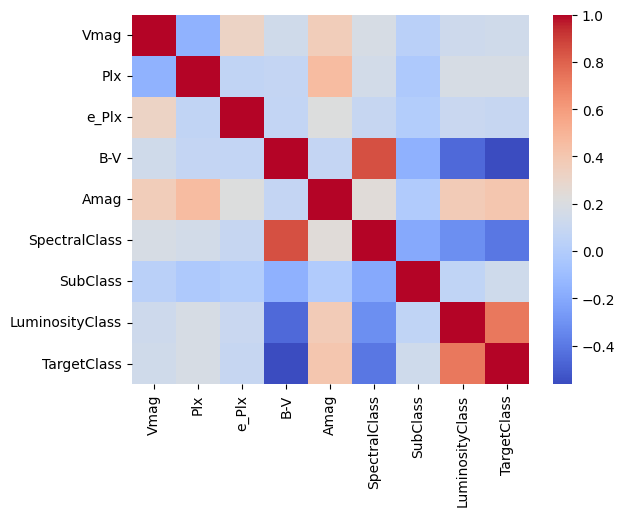

In [290]:
sns.heatmap(df.corr(),cmap="coolwarm")

In [291]:
#Target class has strong correlation with luminosity class, B-v,spectral class and moderate with Amag
Y=df["TargetClass"]
X=df.drop(columns=["TargetClass","Plx","Vmag","e_Plx"])

print(X.head(),Y.head(),sep="\n\n")
X=torch.tensor(X.values,dtype=torch.float32)
Y=torch.tensor(Y.values,dtype=torch.long)

scaler=StandardScaler()
X=scaler.fit_transform(X.numpy())
X=torch.tensor(X,dtype=torch.float32)

joblib.dump(scaler,"scaler.pkl")

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3)
y_train=y_train.float().unsqueeze(1)
y_test=y_test.float().unsqueeze(1)

     B-V       Amag  SpectralClass  SubClass  LuminosityClass
0  0.646  19.483625              4       5.0                7
1  1.840  18.426088              6       1.0                7
2  0.461  18.225480              3       3.0                7
3  0.613  19.692257              4       3.0                3
4  0.872  16.315296              4       6.0                2

0    1
1    1
2    1
3    1
4    0
Name: TargetClass, dtype: int64


In [292]:
model=nn.Sequential(
    nn.Linear(5,20),
    nn.ReLU(),
    nn.Dropout(p=0.1),

    nn.Linear(20,10),
    nn.ReLU(),

    nn.Linear(10,1)
)

In [297]:
criterion=nn.BCEWithLogitsLoss()
optimizer=torch.optim.AdamW(model.parameters(),lr=0.002)
epochs=7000
trainloss=[]
testloss=[]
for i in range(epochs):
    model.train()
    optimizer.zero_grad()
    output=model(X)
    loss=criterion(output,Y.view(-1,1).float())
    loss.backward()

    optimizer.step()
    trainloss.append(loss.item())

    '''model.eval()
    with torch.no_grad():
        output=model(x_test)
        loss_test=criterion(output,y_test)
        testloss.append(loss_test.item())'''
    if i%50==0:
        print(f'Epoch :{i+1}/{epochs},Train loss:{loss.item()}')


Epoch :1/7000,Train loss:0.6656782627105713
Epoch :51/7000,Train loss:0.3339303731918335
Epoch :101/7000,Train loss:0.2106221616268158
Epoch :151/7000,Train loss:0.19261479377746582
Epoch :201/7000,Train loss:0.18703189492225647
Epoch :251/7000,Train loss:0.18008092045783997
Epoch :301/7000,Train loss:0.1758786290884018
Epoch :351/7000,Train loss:0.16640768945217133
Epoch :401/7000,Train loss:0.15306362509727478
Epoch :451/7000,Train loss:0.13491962850093842
Epoch :501/7000,Train loss:0.11087030917406082
Epoch :551/7000,Train loss:0.09264568239450455
Epoch :601/7000,Train loss:0.08087018877267838
Epoch :651/7000,Train loss:0.07291378080844879
Epoch :701/7000,Train loss:0.06854357570409775
Epoch :751/7000,Train loss:0.06626050919294357
Epoch :801/7000,Train loss:0.06597138941287994
Epoch :851/7000,Train loss:0.06379232555627823
Epoch :901/7000,Train loss:0.06226389482617378
Epoch :951/7000,Train loss:0.06056542322039604
Epoch :1001/7000,Train loss:0.06107351556420326
Epoch :1051/7000,Tr

In [ ]:
'''plt.plot(range(epochs),trainloss,label="Train Loss")
plt.plot(range(epochs),testloss,label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss_curve_gen6.png")
plt.show()
plt.close()'''

In [ ]:
torch.save(model.state_dict(),"model6.pth")

In [ ]:
'''from sklearn.metrics import accuracy_score

preds=(torch.sigmoid(model(x_test))>=0.5).int()
acc=accuracy_score(y_test.int(),preds)
print(acc)'''

In [298]:
df=pd.read_csv("/content/test_star.csv")

df["SpectralClass"]=df["SpType"].str[0]
df["SubClass"]=pd.to_numeric(df["SpType"].str[1],errors="coerce")
df["SubClass"]=df["SubClass"].fillna(df["SubClass"].median())

def extract_luminosity(s):
    if pd.isna(s):
        return None
    s=s.replace(":", "")
    match=re.search(r"(Ia|Ib|Iab|I|II|III|IV|V)$", s)
    return match.group(1) if match else None

df["LuminosityClass"]=df["SpType"].apply(extract_luminosity)

df=df.drop(columns="SpType")
df.head()

import joblib

spec_enc=joblib.load("spec_enc.pkl")
lum_enc=joblib.load("lum_enc.pkl")
df["SpectralClass"]=df["SpectralClass"].where(
    df["SpectralClass"].isin(spec_enc.classes_),
    "O" )

df["SpectralClass"]=spec_enc.transform(df["SpectralClass"])
df["LuminosityClass"]=lum_enc.transform(df["LuminosityClass"])

X=df.drop(columns=["Plx","Vmag","e_Plx"])
X.head()


,B-V,Amag,SpectralClass,SubClass,LuminosityClass
0,0.843,16.917019,4,5.0,2
1,1.304,12.919716,5,1.0,2
2,1.019,16.268162,5,1.0,2
3,1.283,13.704777,5,4.0,2
4,1.600,14.275830,5,5.0,2


In [299]:
model.eval()
X_test=torch.tensor(X.values,dtype=torch.float32)
scaler=joblib.load("scaler.pkl")
X=scaler.transform(X.values)
X_test=torch.tensor(X,dtype=torch.float32)

with torch.no_grad():
    probs=torch.sigmoid(model(X_test))
    preds=(probs>=0.5).int().numpy().ravel()

submission=pd.DataFrame({
    "index":df.index,
    "TargetClass":preds
})
submission.to_csv("submission2.csv",index=False)